<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_04_29_GNN_mini_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Batch Training of GNNs


## Acknowledgment:
I borrowed some code from [pytorch-geometric tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)

## References:
```bibtex
@inproceedings{Fey/Lenssen/2019,
  title={Fast Graph Representation Learning with {PyTorch Geometric}},
  author={Fey, Matthias and Lenssen, Jan E.},
  booktitle={ICLR Workshop on Representation Learning on Graphs and Manifolds},
  year={2019},
}
```

```bibtex
@inproceedings{Chiang_2019,
  title={Cluster-GCN: An Efficient Algorithm for Training Deep and Large Graph Convolutional Networks},
  booktitle={Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery &amp; Data Mining},
  publisher={ACM},
  author={Chiang, Wei-Lin and Liu, Xuanqing and Si, Si and Li, Yang and Bengio, Samy and Hsieh, Cho-Jui},
  year={2019}
  }

```

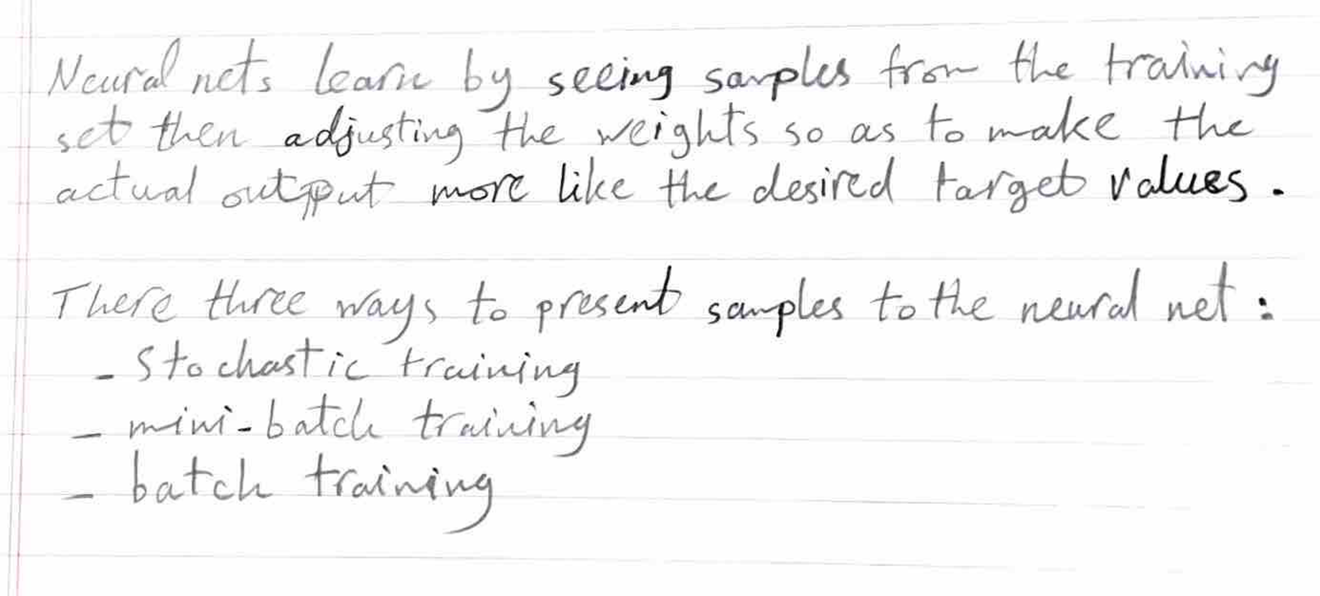

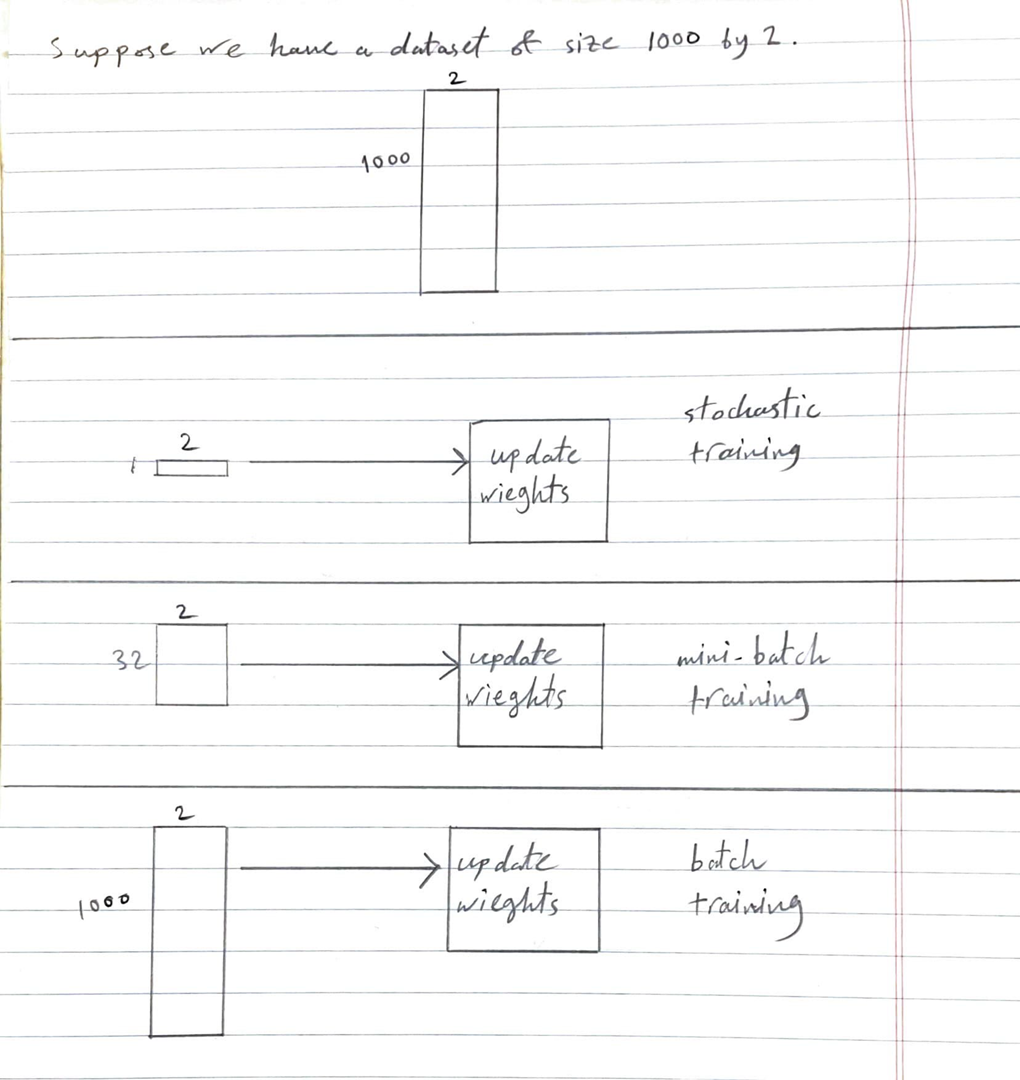

---

image source: [Introduction to Deep Learning by Nandita Bhaskhar](https://cs229.stanford.edu/notes2021fall/section7notes-deep-learning.pdf)

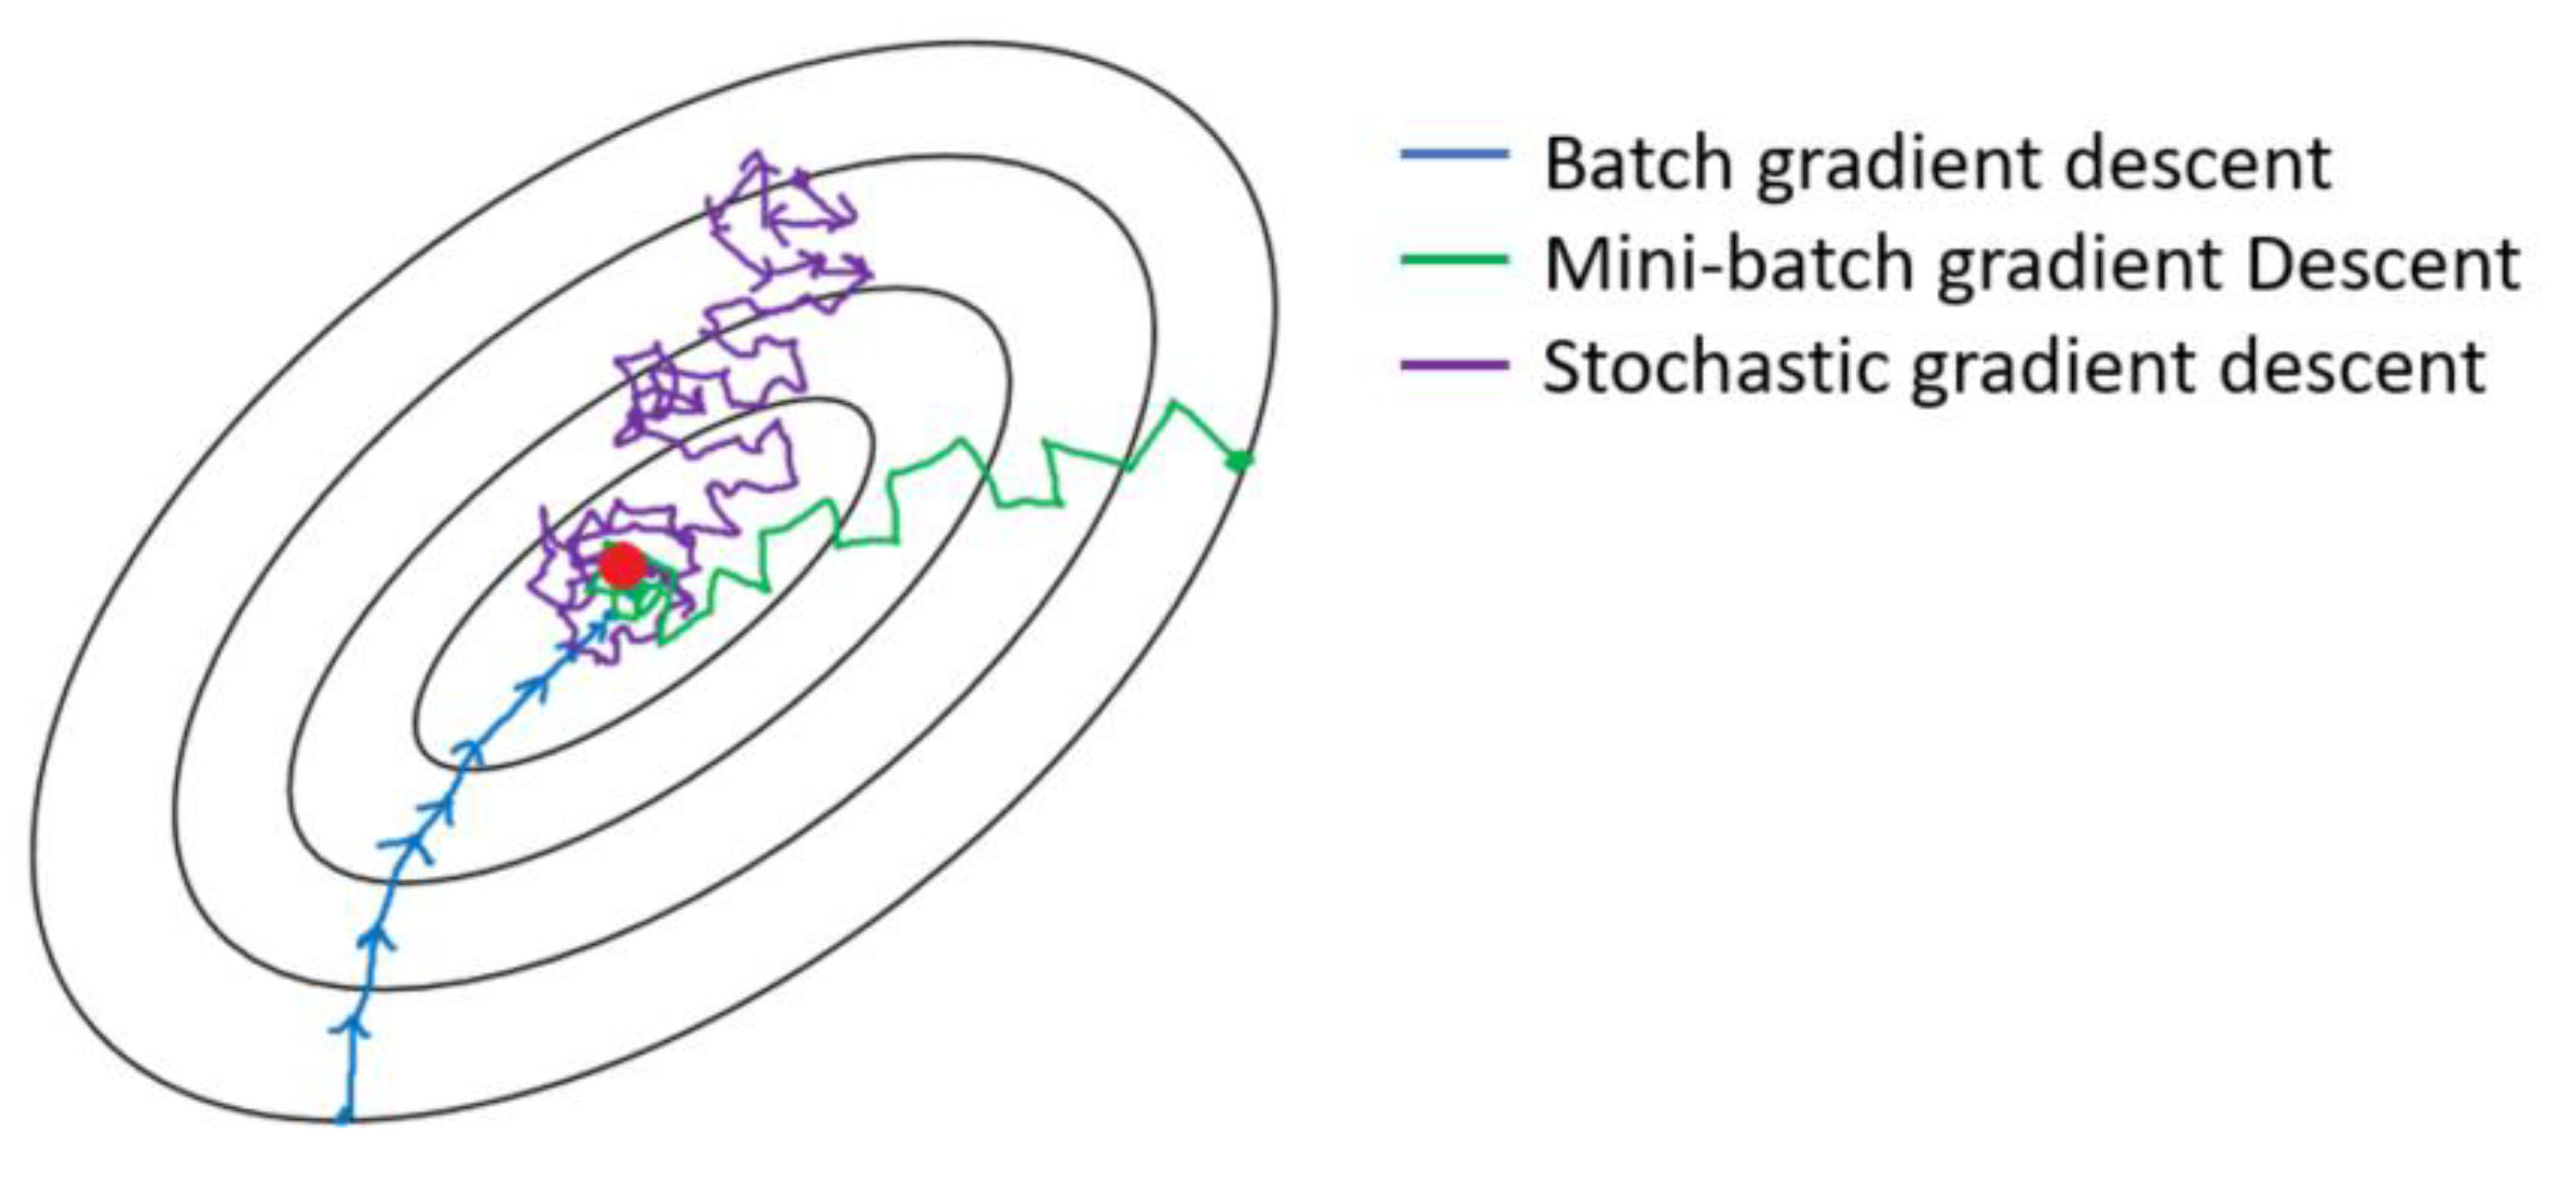

---

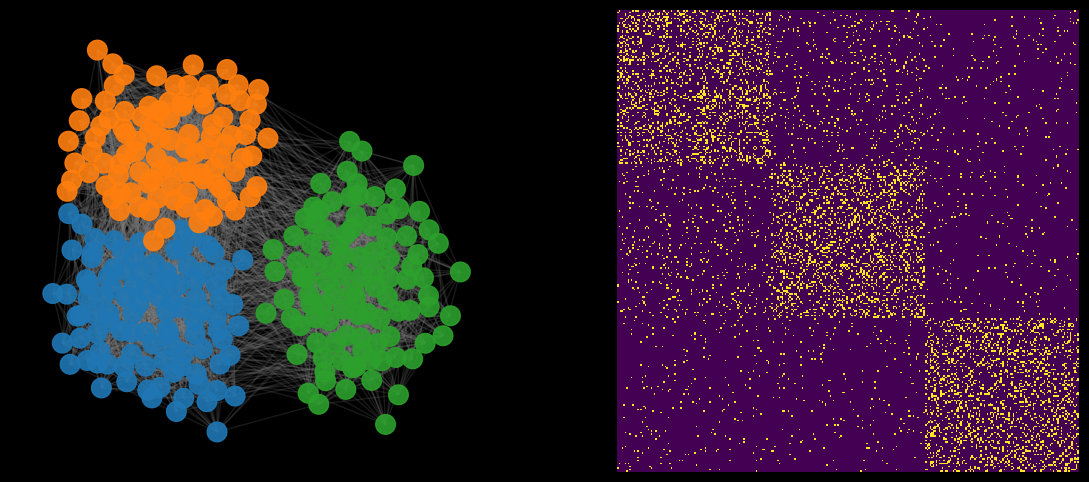

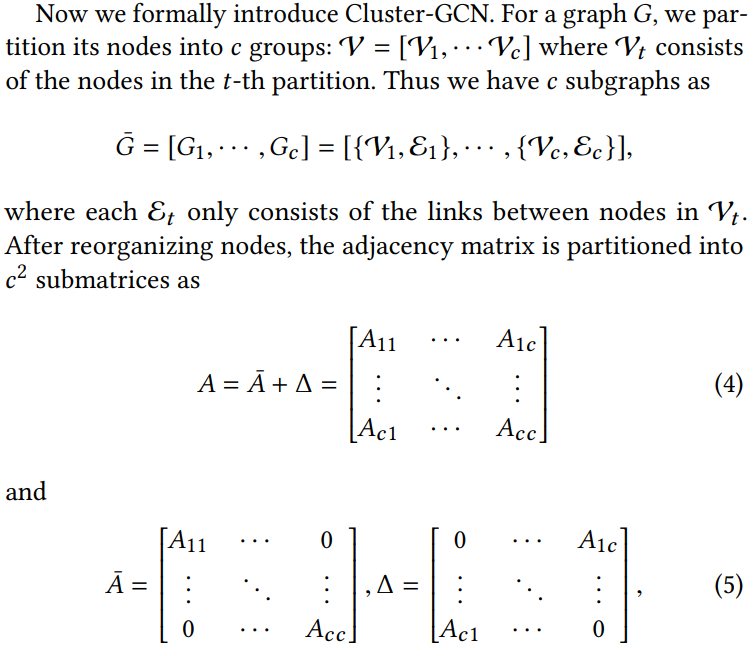

## Install Dependencies

In [ ]:
# install pytorch_geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


If you're using a CPU, check torch version:

`!python -c "import torch; print(torch.__version__)"`

the command to install the dpendencies:

`!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cpu.html`

---

If you're using a GPU, check torch version:

`!python -c "import torch; print(torch.__version__)"`

and CUDA version:

`!python -c "import torch; print(torch.version.cuda)"`

the command to install the dpendencies:

`!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cu121.html`

In [ ]:
!python -c "import torch; print(torch.__version__)"

2.2.1+cu121


In [ ]:
!python -c "import torch; print(torch.version.cuda)"

12.1


In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.1/508.1 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.0/770.0 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 20.1 MB/s eta 0:00:00


## Import libraries

In [ ]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# import pyg_lib
import torch_sparse

# PyTorch geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import ClusterData, ClusterLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric import seed_everything

In [ ]:
random_seed = 42
torch.manual_seed(1234567)
seed_everything(42)
plt.style.use('dark_background')
num_epochs = 101

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data = dataset[0]  # Get the first graph object.
data

Processing...
Done!


Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

In [ ]:
# Gather some statistics about the graph.
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')

Number of nodes:          19717
Number of edges:          88648
Average node degree:      4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


### GCN

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    self.conv1 = GCNConv(num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


In [ ]:
def train(data, mask):
  model.train()
  optimizer.zero_grad()  # Clear gradients.
  out = model(data.x, data.edge_index)  # Perform a single forward pass.
  loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
  loss.backward()  # Derive gradients.
  optimizer.step()  # Update parameters based on gradients.
  return loss

def test(data, mask):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)  # Use the class with highest probability.
  correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
  acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
  return acc

### Training

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for epoch in range(1, num_epochs):
  loss = train(data, data.train_mask)
  if epoch % 10 == 0:
    train_acc = test(data, data.train_mask)
    val_acc = test(data, data.val_mask)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 010, Train: 0.9167
Epoch: 020, Train: 0.9333
Epoch: 030, Train: 0.9333
Epoch: 040, Train: 0.9500
Epoch: 050, Train: 0.9500
Epoch: 060, Train: 0.9667
Epoch: 070, Train: 0.9667
Epoch: 080, Train: 0.9833
Epoch: 090, Train: 1.0000
Epoch: 100, Train: 1.0000


## Testing

In [ ]:
test_acc = test(data, data.test_mask)
test_acc

0.766

## Mini batches

In [ ]:
cluster_data = ClusterData(data, num_parts=128)
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)

total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
  print(f'Batch: {step + 1} has {sub_data.num_nodes} nodes')
  print(sub_data)
  print()
  total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')

Computing METIS partitioning...


Batch: 1 has 4961 nodes
Data(x=[4961, 500], y=[4961], train_mask=[4961], val_mask=[4961], test_mask=[4961], edge_index=[2, 17856])

Batch: 2 has 4912 nodes
Data(x=[4912, 500], y=[4912], train_mask=[4912], val_mask=[4912], test_mask=[4912], edge_index=[2, 17472])

Batch: 3 has 4915 nodes
Data(x=[4915, 500], y=[4915], train_mask=[4915], val_mask=[4915], test_mask=[4915], edge_index=[2, 16548])

Batch: 4 has 4929 nodes
Data(x=[4929, 500], y=[4929], train_mask=[4929], val_mask=[4929], test_mask=[4929], edge_index=[2, 14892])

Iterated over 19717 of 19717 nodes!


Done!


## Training on mini batches

In [ ]:
def train_batch(loader):
  model.train()
  for sub_data in train_loader:  # Iterate over each mini-batch.
    out = model(sub_data.x, sub_data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    optimizer.zero_grad()  # Clear gradients.

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for epoch in range(1, num_epochs):
  loss = train_batch(train_loader)
  if epoch % 10 == 0:
    train_acc = test(data, data.train_mask)
    val_acc = test(data, data.val_mask)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 010, Train: 0.9333
Epoch: 020, Train: 0.9833
Epoch: 030, Train: 1.0000
Epoch: 040, Train: 1.0000
Epoch: 050, Train: 1.0000
Epoch: 060, Train: 1.0000
Epoch: 070, Train: 1.0000
Epoch: 080, Train: 1.0000
Epoch: 090, Train: 1.0000
Epoch: 100, Train: 1.0000


In [ ]:
test_acc = test(data, data.test_mask)
test_acc

0.773